# Import Libraries

In [ ]:
import pandas as pd  
import numpy as np          
import matplotlib.pyplot as plt			
import math
import os
from tqdm import tqdm

from tensorflow import keras
from keras import layers
from keras.layers import Dropout, Dense, SimpleRNN
import tensorflow as tf

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
 
gpus = tf.config.list_physical_devices("GPU")
 
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  
    tf.config.set_visible_devices([gpus[0]],"GPU")

# Read dataset

In [6]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:
# Import the stock data, calculate the return rate change for each stock
# and compute the logarithm of the trading volume.
def load_data(data):

    # Pivot the data by time and stock code to rearrange the closing prices.
    price = data.pivot_table(index='time', columns='tic', values='close')

    # Calculate the logarithmic return (log return)
    ret = np.diff(np.log(price), axis=0)
    ret_df = pd.DataFrame(ret, index=price.index[1:], columns=price.columns)
    
    return ret_df

In [ ]:
train_ret = load_data(train_data)
test_ret = load_data(test_data)

# Prepare dataset with windowing

Suppose the target history data length is $k$, the feature for each data should be $T{n-k}:T{n}$, and the target data should be $T{n}$. So we should pair each data sample into this form

In [ ]:
def data_prepare(data, min_before, time_step):

    x_train = []
    y_train = []

    for i in tqdm(range(len(data))):

        # If the data does not go out of bounds
        left_data_len = len(data)-i - min_before -1 - time_step
        if left_data_len<0:
            pass
        else:
            # Collect x data
            x_data= data.iloc[i: i + min_before]
            x_col_list = []

            for _ in range(len(data.columns)):
                x_col = x_data.iloc[:,_].to_list()
                x_col_list.append(x_col)

            x_train.append(x_col_list)


            # Collect y data
            y_data = data.iloc[i + min_before + time_step].to_list()
            y_train.append(y_data)

    return x_train, y_train


# Build model and Predict

## Use first 15 minutes to predict the 16 minute data

In [15]:
x_train_pre, y_train_pre = data_prepare(train_ret, 15, 0)
x_test_pre, y_test_pre = data_prepare(test_ret, 15, 0)

100%|██████████| 10559/10559 [00:08<00:00, 1278.04it/s]


In [ ]:
def x_y_prepare(x_train, y_train, x_test, y_test):

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Convert x_train_array and y_train_array to PyTorch tensors
    x_train = np.reshape(x_train, (x_train.shape[0], 15, 15))
    x_test = np.reshape(x_test, (x_test.shape[0], 15, 15))

    print(f'x_train shape is: {x_train.shape}, y_train shape is {y_train.shape}')
    print(f'x_test shape is: {x_test.shape}, y_test shape is {y_test.shape}')

    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = x_y_prepare(x_train_pre, y_train_pre, x_test_pre, y_test_pre)

x_train shape is: (29744, 15, 15), y_train shape is (29744, 15)
x_test shape is: (10544, 15, 15), y_test shape is (10544, 15)


In [ ]:
def RNN_model(x_train, y_train, x_test, y_test):

    # Build a simple rnn model with dropout regularization method
    model = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True), 
        Dropout(0.1),                        
        SimpleRNN(100),
        Dropout(0.1),
        Dense(15)
    ])
    
    # compile the rnn model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mean_squared_error')  # loss function for mse
    
    # train model and store history info
    history = model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        validation_freq=1)                  
    
    # print out the model architeture
    model.summary()

    return history, model

history, model = RNN_model(x_train, y_train, x_test, y_test)

Epoch 1/10
465/465 [==============================] - 47s 96ms/step - loss: 6.4028e-05 - val_loss: 8.3922e-06
Epoch 2/10
465/465 [==============================] - 46s 99ms/step - loss: 7.9265e-06 - val_loss: 6.5176e-06
Epoch 3/10
465/465 [==============================] - 48s 103ms/step - loss: 5.8527e-06 - val_loss: 6.0498e-06
Epoch 4/10
465/465 [==============================] - 53s 114ms/step - loss: 5.1390e-06 - val_loss: 5.8441e-06
Epoch 5/10
465/465 [==============================] - 48s 103ms/step - loss: 4.8359e-06 - val_loss: 5.8436e-06
Epoch 6/10
465/465 [==============================] - 48s 103ms/step - loss: 4.6687e-06 - val_loss: 5.7734e-06
Epoch 7/10
465/465 [==============================] - 50s 107ms/step - loss: 4.5577e-06 - val_loss: 5.7392e-06
Epoch 8/10
465/465 [==============================] - 50s 106ms/step - loss: 4.4941e-06 - val_loss: 5.8412e-06
Epoch 9/10
465/465 [==============================] - 49s 106ms/step - loss: 4.4669e-06 - val_loss: 5.7960e-06
Epo

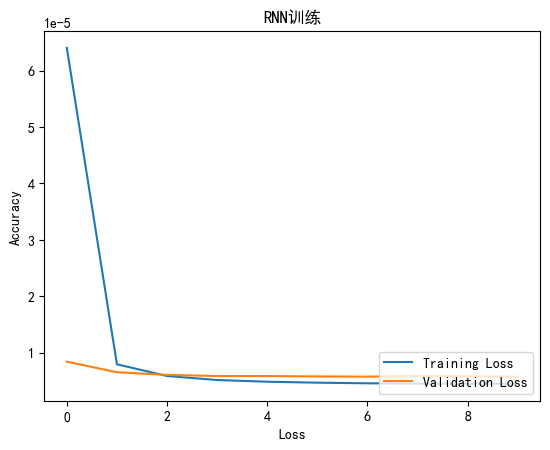

In [ ]:
# print history train and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('RNN训练')
plt.legend(loc='lower right')
plt.show()

330/330 [==============================] - 5s 14ms/step


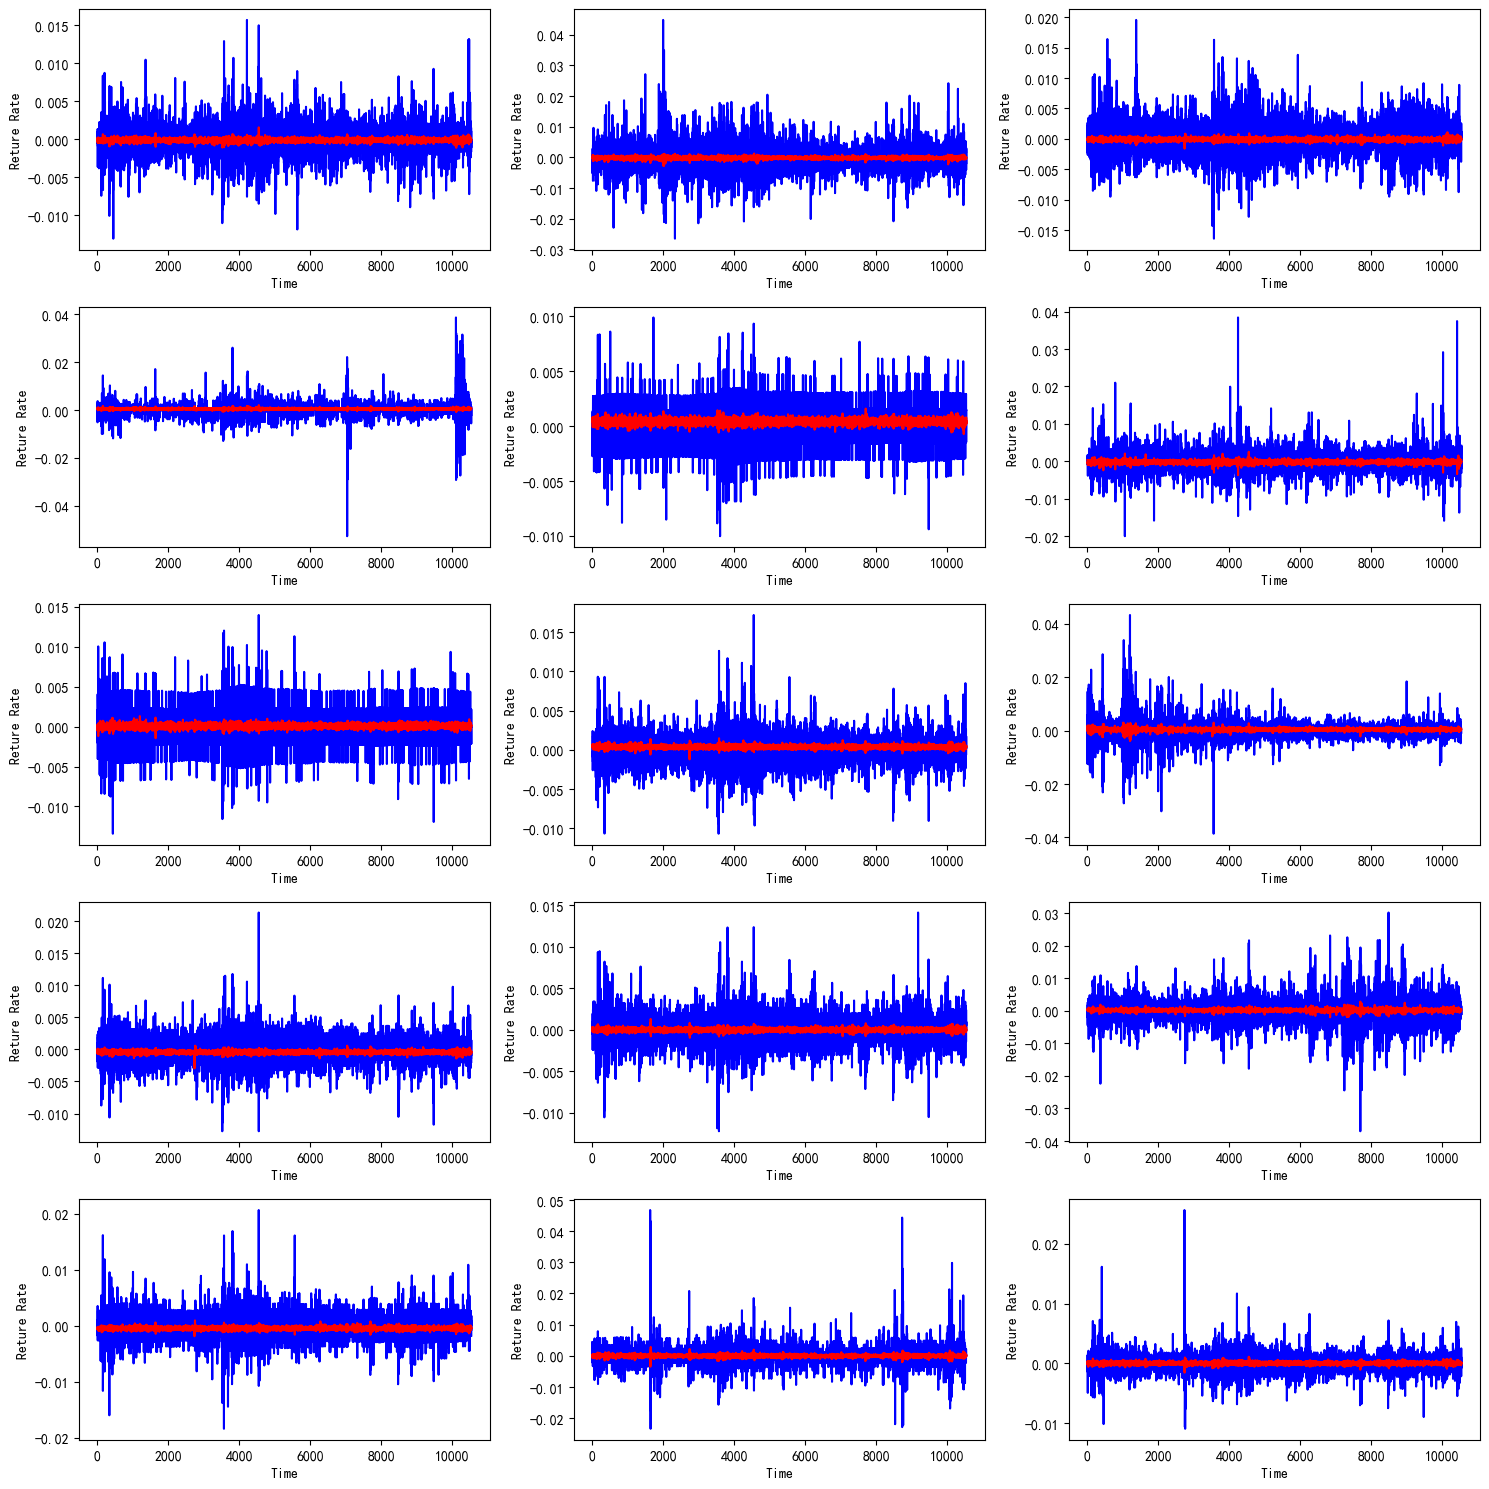

In [ ]:
# predict stock price return rate for each time step
predicted_stock_price = model.predict(x_test)     

fig, axes = plt.subplots(5,3,figsize=(15,15))
for i in range(5):
    for j in range(3):

        ax = axes[i,j]
        index = i*3+j

        real_result = [a[index] for a in y_test]
        pred_result = [a[index] for a in predicted_stock_price]

        ax.plot(real_result, color='blue', label='Stock Price')
        ax.plot(pred_result, color='red', label='Predicted Stock Price')

        ax.set_xlabel('Time')
        ax.set_ylabel('Reture Rate')

plt.tight_layout()
plt.show()

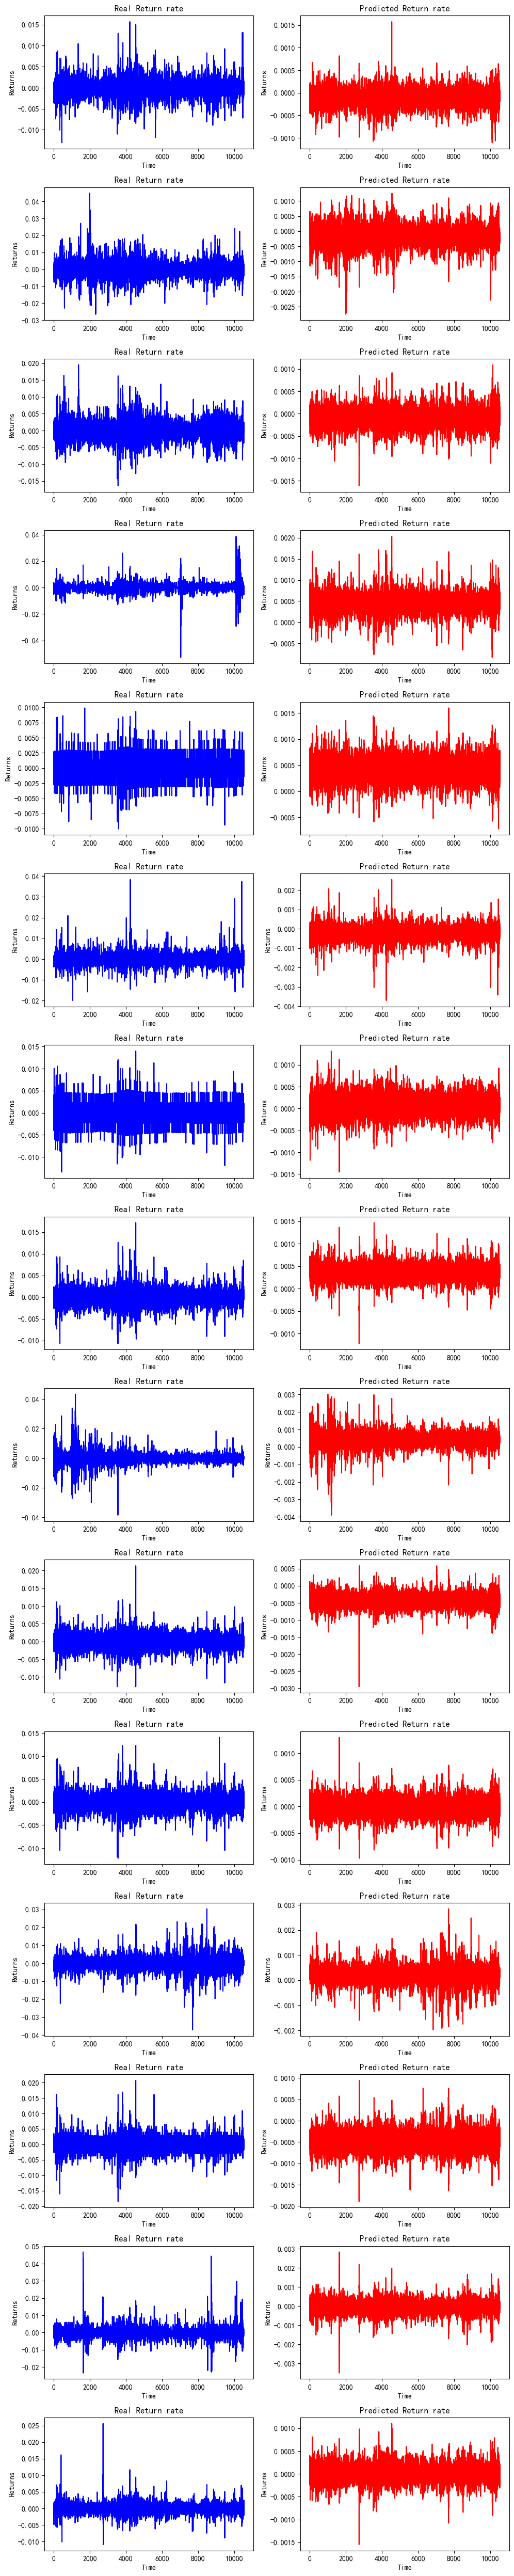

In [30]:
fig, axes = plt.subplots(15,2,figsize=(10,50))

for i in range(15):

    ax0 = axes[i,0]
    real_result = [a[i] for a in y_test]
    ax0.plot(real_result, color='blue')
    ax0.set_title('Real Return rate')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Returns')


    ax1 = axes[i,1]
    pred_result = [a[i] for a in predicted_stock_price]
    ax1.plot(pred_result, color='red')
    ax1.set_title('Predicted Return rate')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Returns')

plt.tight_layout()
plt.show()

## Use first 15 minutes to predict the 17 minute data

In [21]:
x_train_pre, y_train_pre = data_prepare(train_ret, 15, 1)
x_test_pre, y_test_pre = data_prepare(test_ret, 15, 1)

100%|██████████| 10559/10559 [00:08<00:00, 1186.41it/s]


In [22]:
x_train, y_train, x_test, y_test = x_y_prepare(x_train_pre, y_train_pre, x_test_pre, y_test_pre)

x_train shape is: (29743, 15, 15), y_train shape is (29743, 15)
x_test shape is: (10543, 15, 15), y_test shape is (10543, 15)


In [23]:
history1, model1 = RNN_model(x_train, y_train, x_test, y_test)

Epoch 1/10
465/465 [==============================] - 48s 100ms/step - loss: 4.9476e-05 - val_loss: 7.7765e-06
Epoch 2/10
465/465 [==============================] - 44s 95ms/step - loss: 7.0660e-06 - val_loss: 6.2277e-06
Epoch 3/10
465/465 [==============================] - 37s 79ms/step - loss: 5.5156e-06 - val_loss: 5.9669e-06
Epoch 4/10
465/465 [==============================] - 42s 91ms/step - loss: 4.9942e-06 - val_loss: 5.8779e-06
Epoch 5/10
465/465 [==============================] - 42s 91ms/step - loss: 4.7605e-06 - val_loss: 5.9595e-06
Epoch 6/10
465/465 [==============================] - 39s 83ms/step - loss: 4.6099e-06 - val_loss: 5.8861e-06
Epoch 7/10
465/465 [==============================] - 45s 98ms/step - loss: 4.5417e-06 - val_loss: 5.9368e-06
Epoch 8/10
465/465 [==============================] - 51s 110ms/step - loss: 4.5030e-06 - val_loss: 5.8848e-06
Epoch 9/10
465/465 [==============================] - 47s 101ms/step - loss: 4.4887e-06 - val_loss: 5.9020e-06
Epoch 1

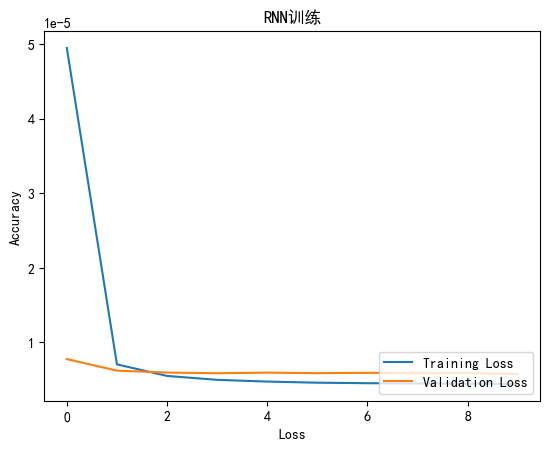

In [28]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('RNN训练')
plt.legend(loc='lower right')
plt.show()

330/330 [==============================] - 5s 15ms/step


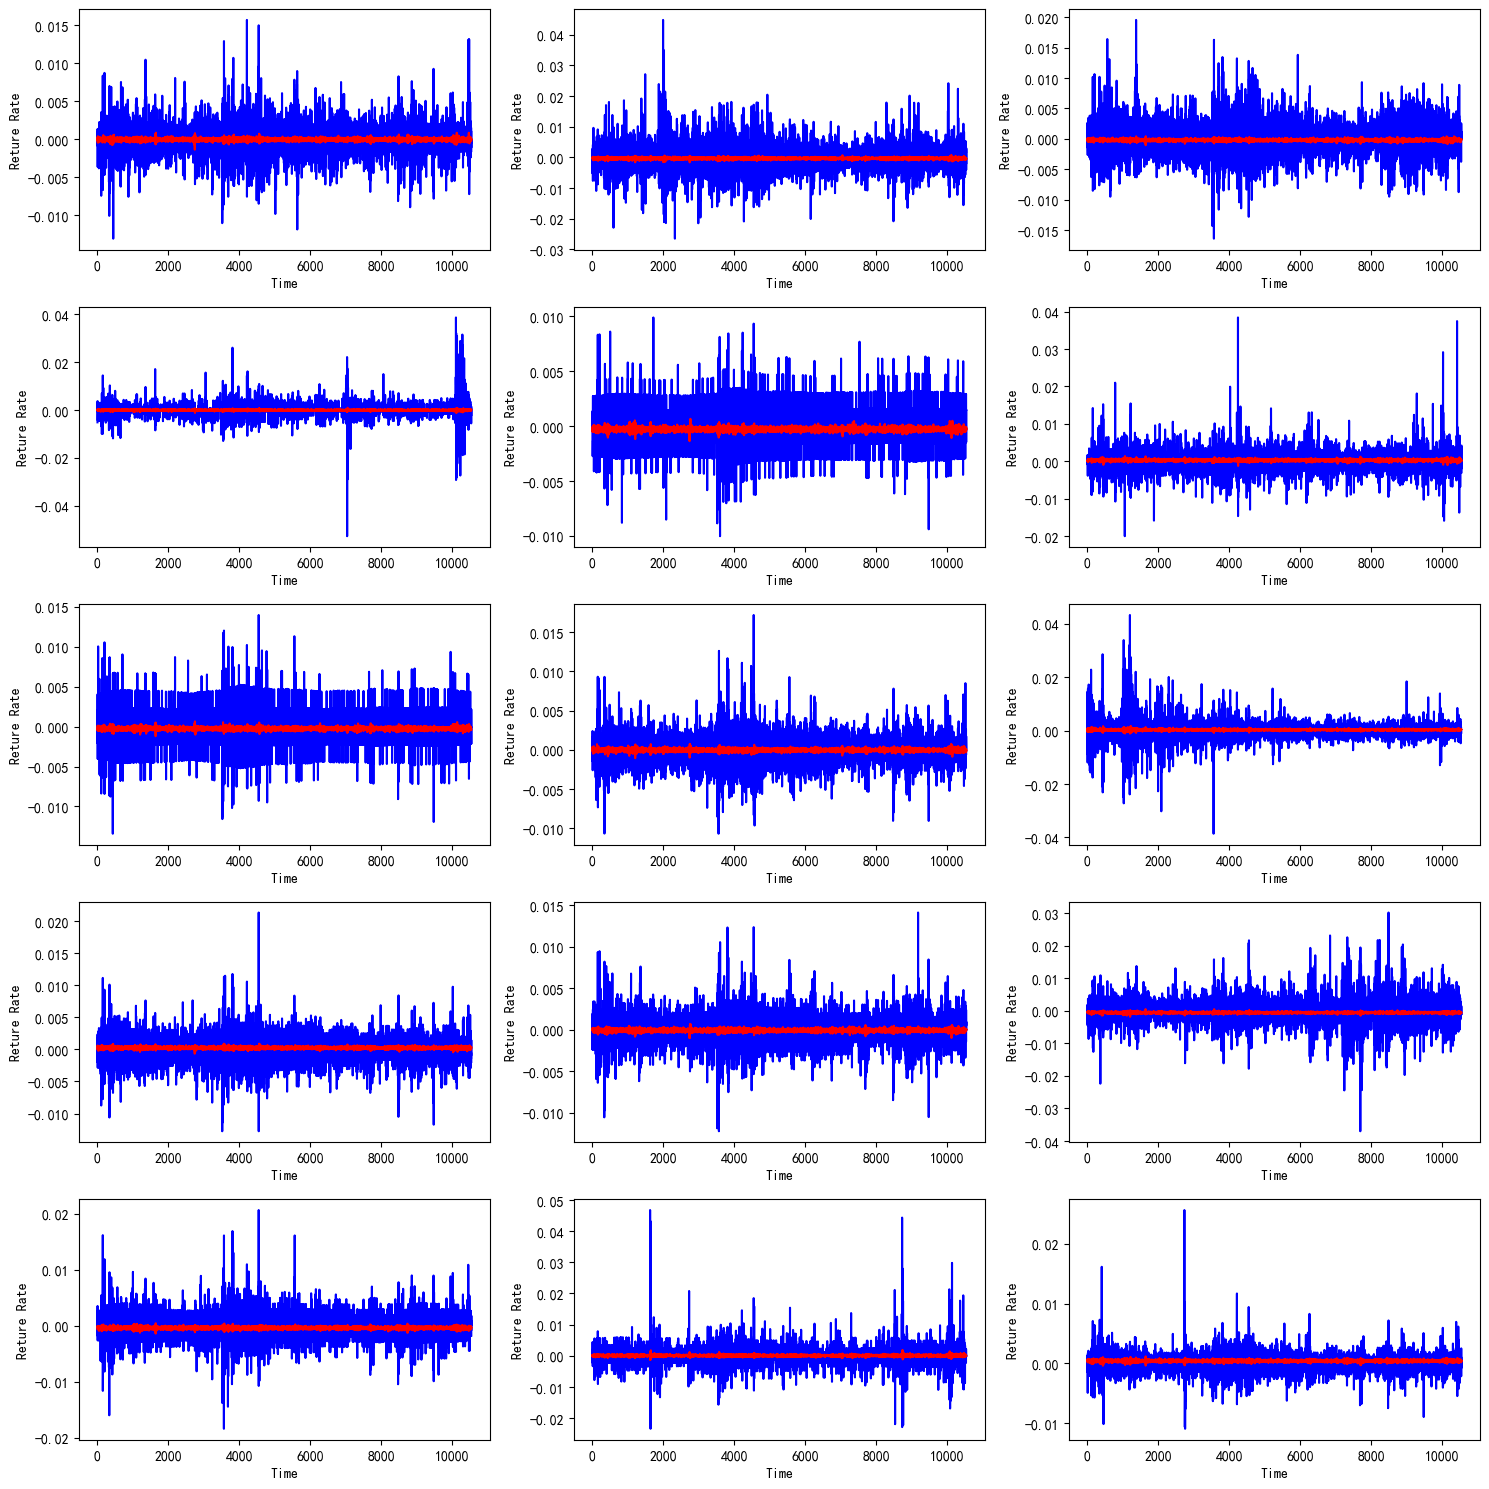

In [37]:
predicted_stock_price1 = model1.predict(x_test)     

fig, axes = plt.subplots(5,3,figsize=(15,15))

for i in range(5):
    for j in range(3):

        ax = axes[i,j]
        index = i*3+j

        real_result = [a[index] for a in y_test]
        pred_result = [a[index] for a in predicted_stock_price1]

        ax.plot(real_result, color='blue', label='Stock Price')
        ax.plot(pred_result, color='red', label='Predicted Stock Price')

        ax.set_xlabel('Time')
        ax.set_ylabel('Reture Rate')

plt.tight_layout()
plt.show()

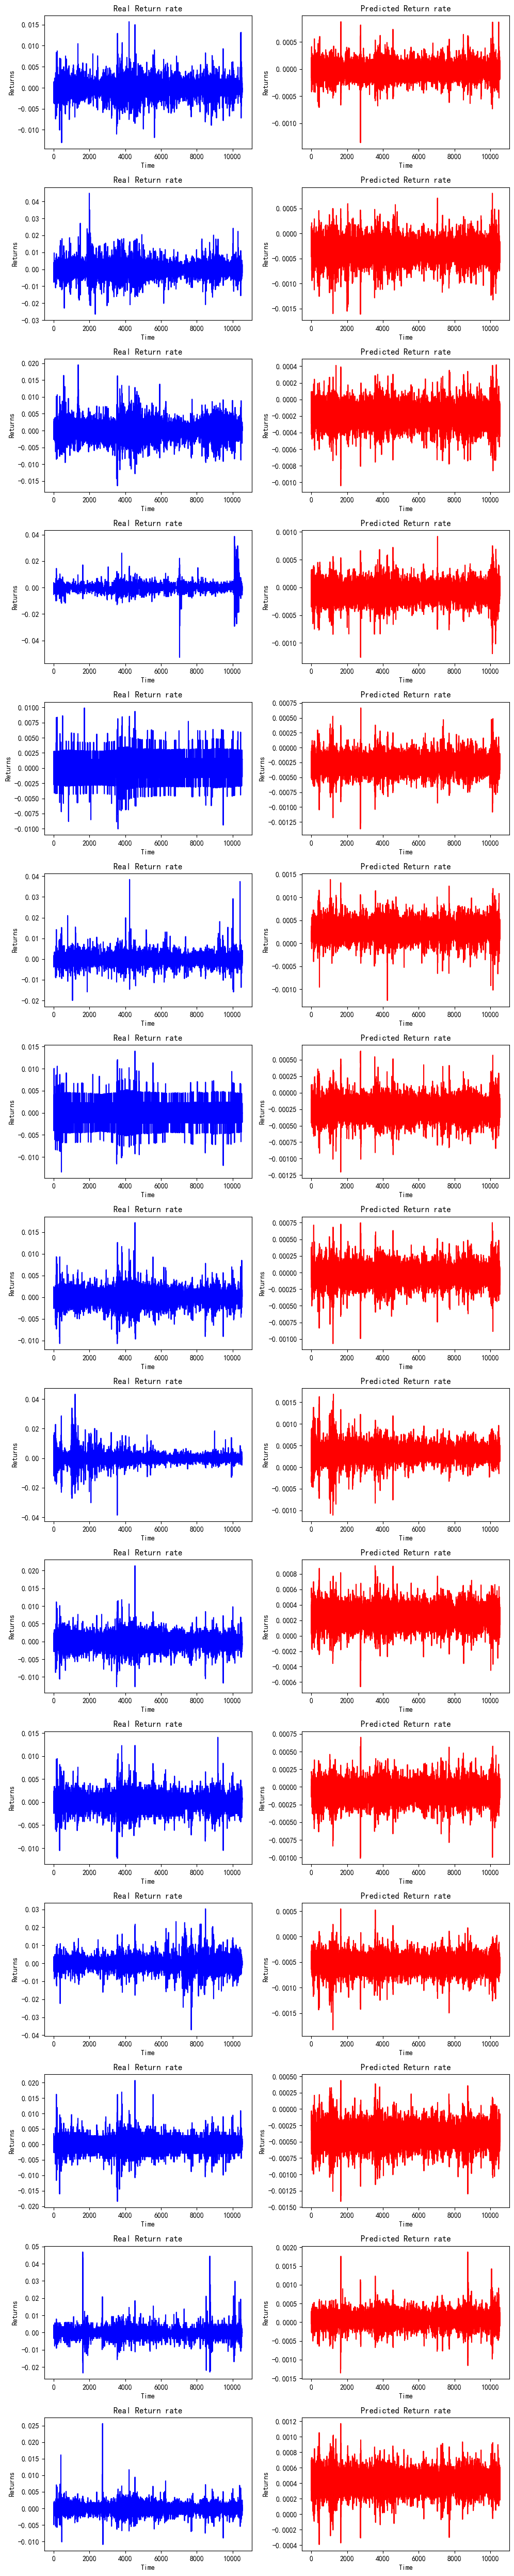

In [38]:
fig, axes = plt.subplots(15,2,figsize=(10,50))

for i in range(15):

    ax0 = axes[i,0]
    real_result = [a[i] for a in y_test]
    ax0.plot(real_result, color='blue')
    ax0.set_title('Real Return rate')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Returns')


    ax1 = axes[i,1]
    pred_result = [a[i] for a in predicted_stock_price1]
    ax1.plot(pred_result, color='red')
    ax1.set_title('Predicted Return rate')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Returns')

plt.tight_layout()
plt.show()

## Use first 15 minutes to predict the 18 minute data

In [32]:
x_train_pre, y_train_pre = data_prepare(train_ret, 15, 2)
x_test_pre, y_test_pre = data_prepare(test_ret, 15, 2)

100%|██████████| 10559/10559 [00:08<00:00, 1293.97it/s]


In [34]:
x_train, y_train, x_test, y_test = x_y_prepare(x_train_pre, y_train_pre, x_test_pre, y_test_pre)

x_train shape is: (29742, 15, 15), y_train shape is (29742, 15)
x_test shape is: (10542, 15, 15), y_test shape is (10542, 15)


In [39]:
history2, model2 = RNN_model(x_train, y_train, x_test, y_test)

Epoch 1/10
465/465 [==============================] - 45s 94ms/step - loss: 4.5404e-05 - val_loss: 7.5955e-06
Epoch 2/10
465/465 [==============================] - 46s 100ms/step - loss: 6.9785e-06 - val_loss: 6.2592e-06
Epoch 3/10
465/465 [==============================] - 45s 97ms/step - loss: 5.4941e-06 - val_loss: 6.0429e-06
Epoch 4/10
465/465 [==============================] - 47s 100ms/step - loss: 4.9776e-06 - val_loss: 5.9756e-06
Epoch 5/10
465/465 [==============================] - 43s 93ms/step - loss: 4.7493e-06 - val_loss: 5.8570e-06
Epoch 6/10
465/465 [==============================] - 47s 101ms/step - loss: 4.5999e-06 - val_loss: 5.7991e-06
Epoch 7/10
465/465 [==============================] - 45s 98ms/step - loss: 4.5381e-06 - val_loss: 6.0129e-06
Epoch 8/10
465/465 [==============================] - 47s 100ms/step - loss: 4.4954e-06 - val_loss: 5.7990e-06
Epoch 9/10
465/465 [==============================] - 44s 95ms/step - loss: 4.4743e-06 - val_loss: 5.8125e-06
Epoch 

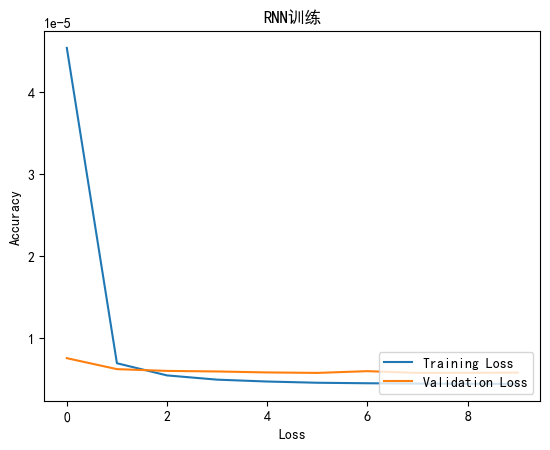

In [40]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('RNN训练')
plt.legend(loc='lower right')
plt.show()

330/330 [==============================] - 5s 14ms/step


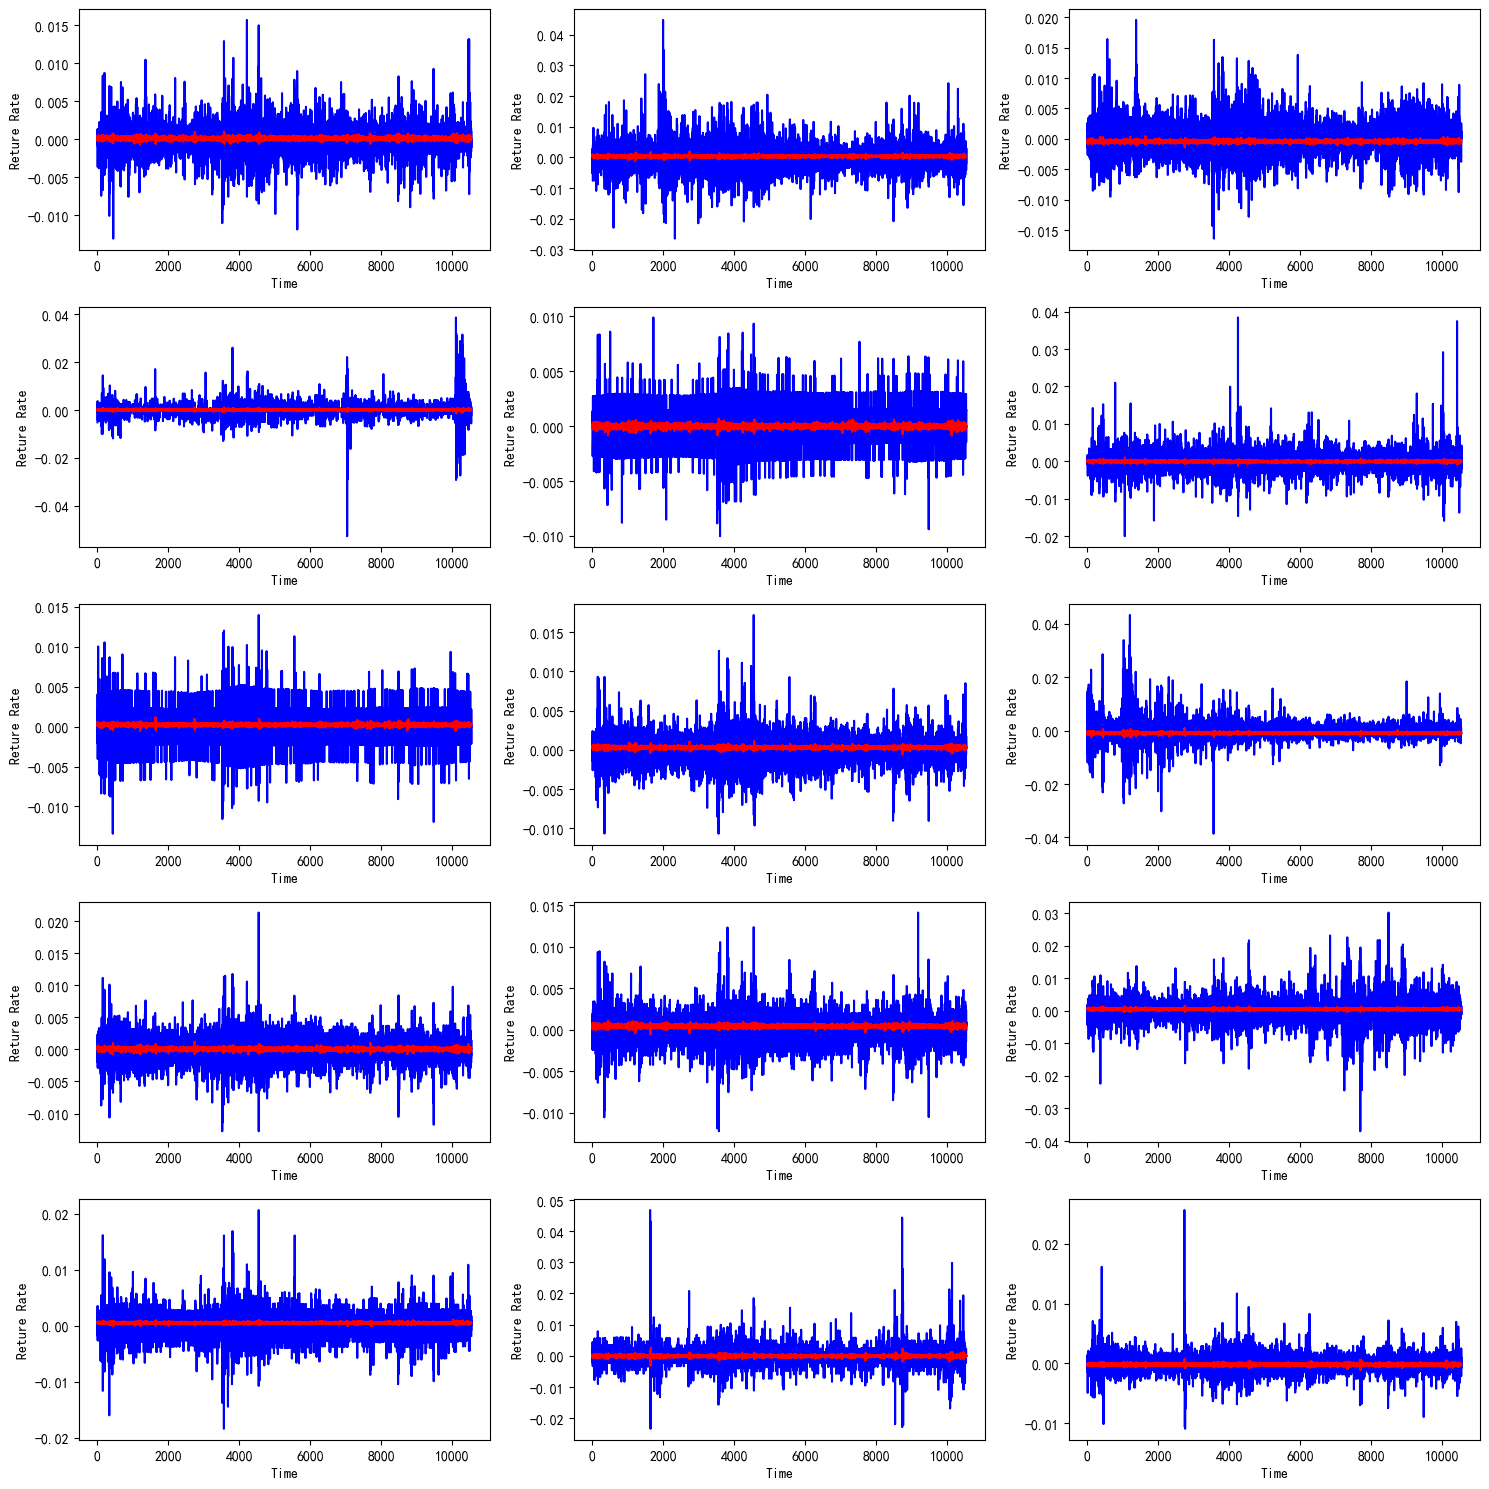

In [41]:
predicted_stock_price2 = model2.predict(x_test)     

fig, axes = plt.subplots(5,3,figsize=(15,15))

for i in range(5):
    for j in range(3):

        ax = axes[i,j]
        index = i*3+j

        real_result = [a[index] for a in y_test]
        pred_result = [a[index] for a in predicted_stock_price2]

        ax.plot(real_result, color='blue', label='Stock Price')
        ax.plot(pred_result, color='red', label='Predicted Stock Price')

        ax.set_xlabel('Time')
        ax.set_ylabel('Reture Rate')

plt.tight_layout()
plt.show()

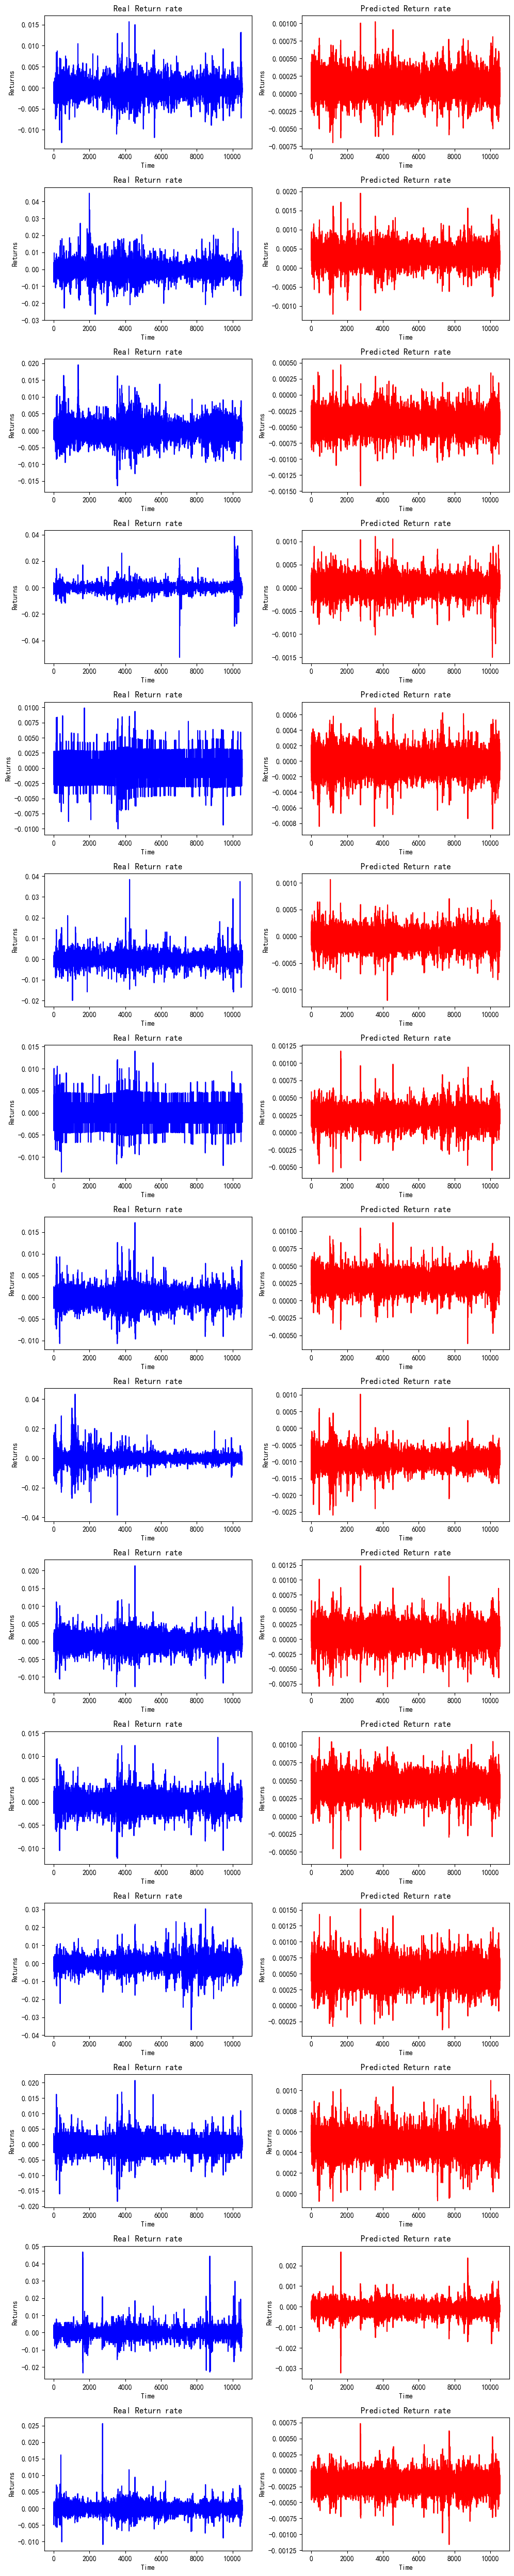

In [42]:
fig, axes = plt.subplots(15,2,figsize=(10,50))

for i in range(15):

    ax0 = axes[i,0]
    real_result = [a[i] for a in y_test]
    ax0.plot(real_result, color='blue')
    ax0.set_title('Real Return rate')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Returns')


    ax1 = axes[i,1]
    pred_result = [a[i] for a in predicted_stock_price2]
    ax1.plot(pred_result, color='red')
    ax1.set_title('Predicted Return rate')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Returns')

plt.tight_layout()
plt.show()